In [22]:
#–Load and Plot Raw Price Data
import sys
import os

# 🛠 Add the 'src' directory to Python's module search path
sys.path.append(os.path.abspath("../src"))

In [25]:
from data_loader import load_and_clean_data
from preprocessing import compute_log_returns
from change_point_model import run_bayesian_change_point_model


In [5]:
# 📥 Load and clean Brent oil price data
df = load_and_clean_data("../data/BrentOilPrices.csv")

# 🔁 Compute log returns for modeling
df = compute_log_returns(df)

# 🎯 Extract the series we'll use
log_returns = df['LogReturn'].dropna()


In [6]:
# 🔁 Run Bayesian change point model
model, trace = run_bayesian_change_point_model(log_returns)


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>NUTS: [mu1, mu2, sigma1, sigma2]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 28250 seconds.


In [7]:
import arviz as az

# Save the PyMC trace to ../data/
az.to_netcdf(trace, "../data/bayesian_trace.nc")


'../data/bayesian_trace.nc'

In [8]:
import arviz as az

# 📊 Show summary of posterior estimates
az.summary(trace, var_names=["mu1", "mu2", "sigma1", "sigma2", "tau"])


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu1,0.000,0.000,-0.000,0.001,0.000,0.00,5410.0,2918.0,1.0
mu2,-0.000,0.000,-0.001,0.001,0.000,0.00,5962.0,3211.0,1.0
sigma1,0.023,0.000,0.023,0.023,0.000,0.00,6117.0,3082.0,1.0
sigma2,0.029,0.000,0.028,0.030,0.000,0.00,6711.0,3371.0,1.0
tau,5387.974,20.575,5345.000,5418.000,0.925,0.67,537.0,466.0,1.0


array([[<Axes: title={'center': 'mu1'}>, <Axes: title={'center': 'mu1'}>],
       [<Axes: title={'center': 'mu2'}>, <Axes: title={'center': 'mu2'}>],
       [<Axes: title={'center': 'sigma1'}>,
        <Axes: title={'center': 'sigma1'}>],
       [<Axes: title={'center': 'sigma2'}>,
        <Axes: title={'center': 'sigma2'}>],
       [<Axes: title={'center': 'tau'}>, <Axes: title={'center': 'tau'}>]],
      dtype=object)

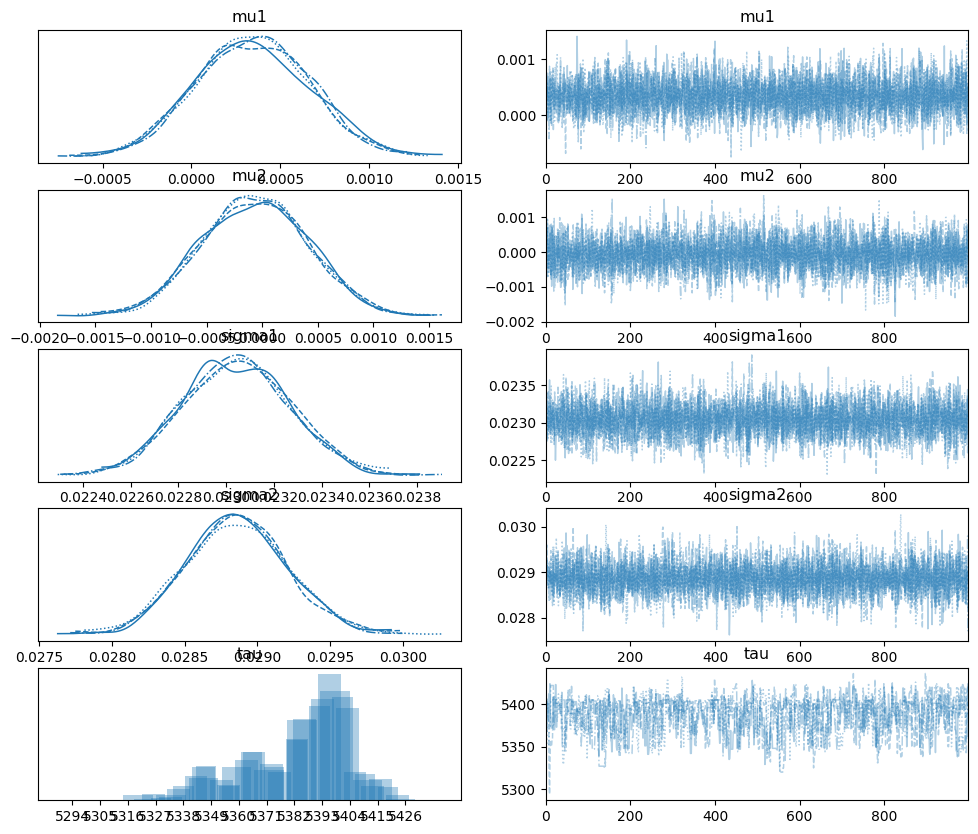

In [9]:
az.plot_trace(trace, var_names=["mu1", "mu2", "sigma1", "sigma2", "tau"])


Trace Plot Analysis – MCMC Convergence & Parameter Distributions

This visualization combines two key aspects for each parameter:

Left side: Posterior distribution (how likely each parameter value is after seeing the data)

Right side: Trace plot (sampling path from Markov Chain Monte Carlo)

🧠 What This Is Telling Us
This plot helps us trust the model's results. It checks whether:

The parameter estimates are stable

The model has explored the parameter space well

The results are interpretable for business or economic insight

🔍 Parameter-by-Parameter Interpretation




Parameter	Meaning in Oil Price Context	Technical Interpretation
mu1	Average return (price change rate) before a structural shift	Posterior centered around ~0 → little or no consistent price trend before the shift
mu2	Average return after the shift	Also ~0 → no sustained trend after the shift either
sigma1	Volatility (price fluctuations) before change point	Lower variance (~0.023), meaning the oil market was relatively stable
sigma2	Volatility after change point	Higher variance (~0.029), indicating increased market instability or shocks
tau	Index of the change point in the time series (e.g. when volatility changed)	Sharp peak around 5388, showing a clear and confident detection of when the market behavior changed

✅ Technical Health Check
All chains converged well: r_hat = 1.0 for every parameter

No divergences or instability

Posterior distributions are smooth and unimodal

Sampling paths (right plots) show no drift, confirming the model explored the space thoroughly

📌 Overall Message
"Our Bayesian model has confidently identified a point in the time series (~index 5388) where the volatility of Brent oil prices increased significantly, even though the average return before and after that point remained near zero. This suggests a shift from a stable to a more volatile market, not due to consistent price increase or decrease, but due to unpredictable swings."

In [10]:
import numpy as np

# 🎯 Median tau (change point index)
tau_median = int(np.median(trace.posterior["tau"].values))

# 📅 Convert index to date
change_date = df['Date'].iloc[tau_median]
print(f"Detected change point at index {tau_median} → Date: {change_date.date()}")


Detected change point at index 5393 → Date: 2008-08-04


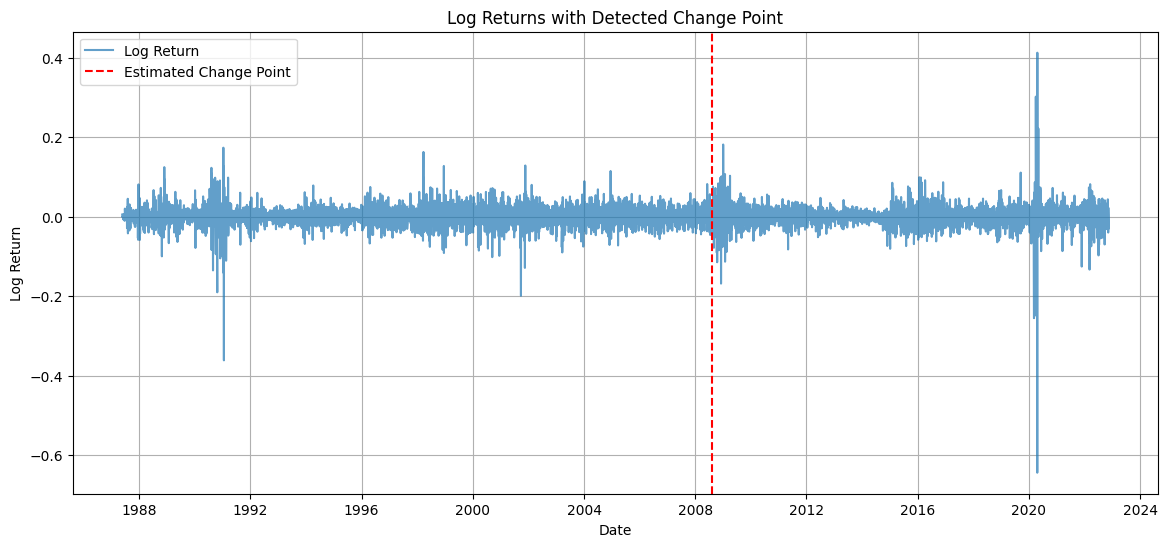

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))
plt.plot(df['Date'].iloc[1:], df['LogReturn'].iloc[1:], label="Log Return", alpha=0.7)
plt.axvline(change_date, color='red', linestyle='--', label="Estimated Change Point")
plt.title("Log Returns with Detected Change Point")
plt.xlabel("Date")
plt.ylabel("Log Return")
plt.legend()
plt.grid(True)
plt.show()



array([[<Axes: title={'center': 'mu1'}>, <Axes: title={'center': 'mu2'}>,
        <Axes: title={'center': 'sigma1'}>],
       [<Axes: title={'center': 'sigma2'}>,
        <Axes: title={'center': 'tau'}>, <Axes: >]], dtype=object)

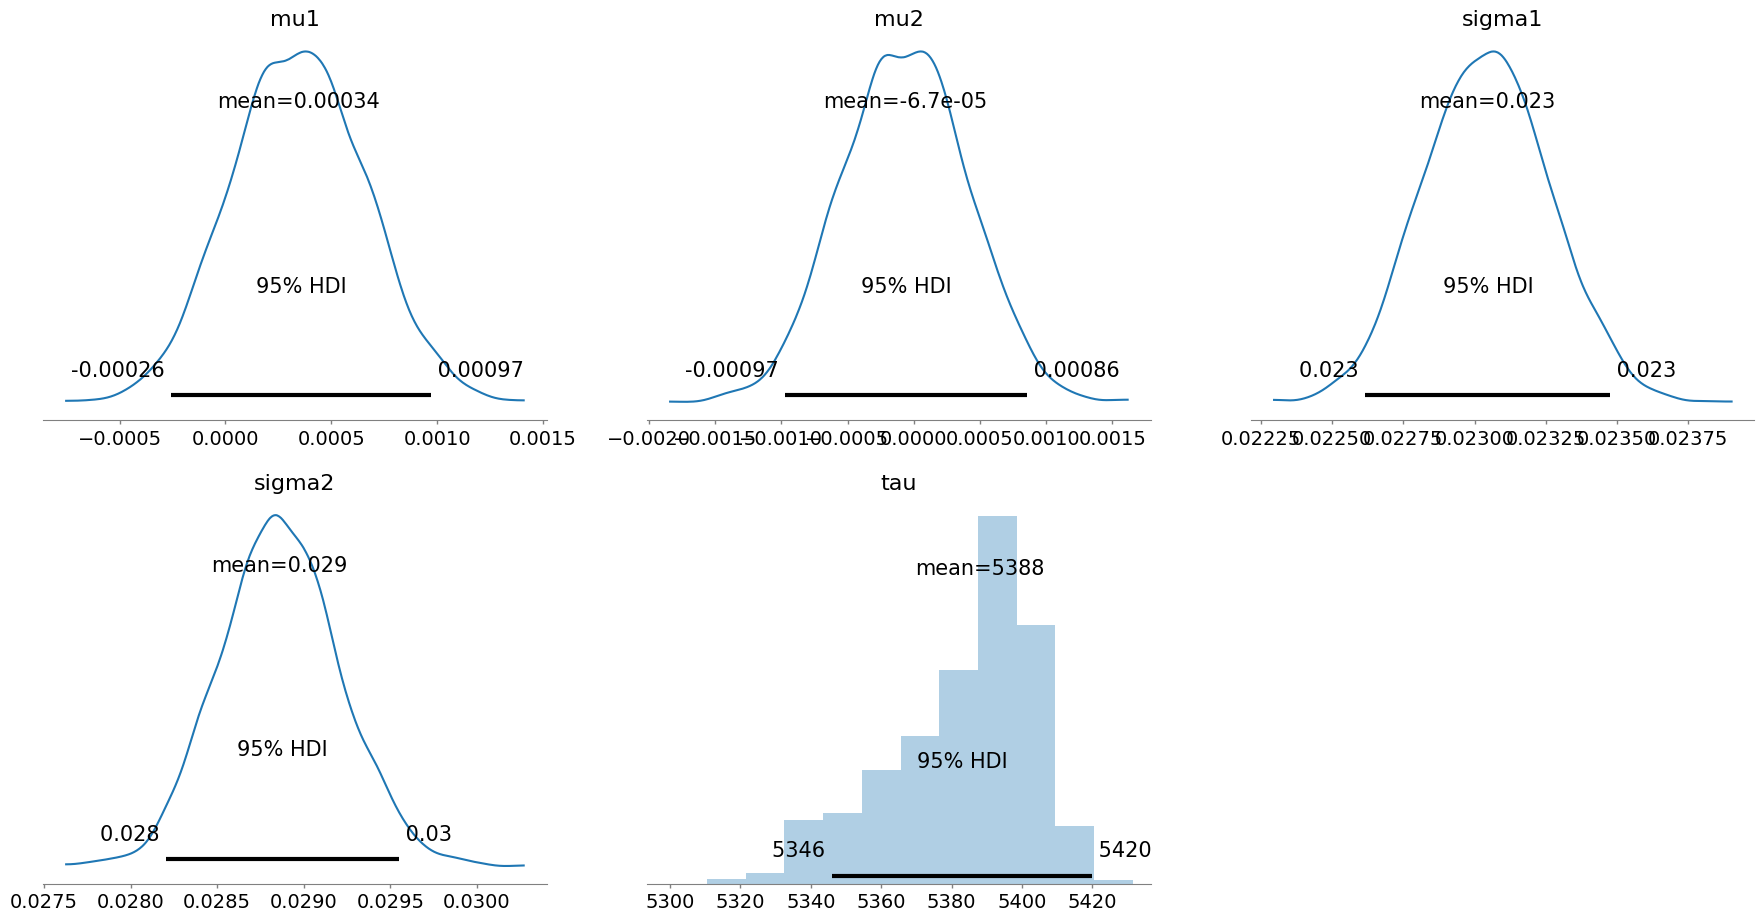

In [13]:
az.plot_posterior(trace, var_names=["mu1", "mu2", "sigma1", "sigma2", "tau"], hdi_prob=0.95)


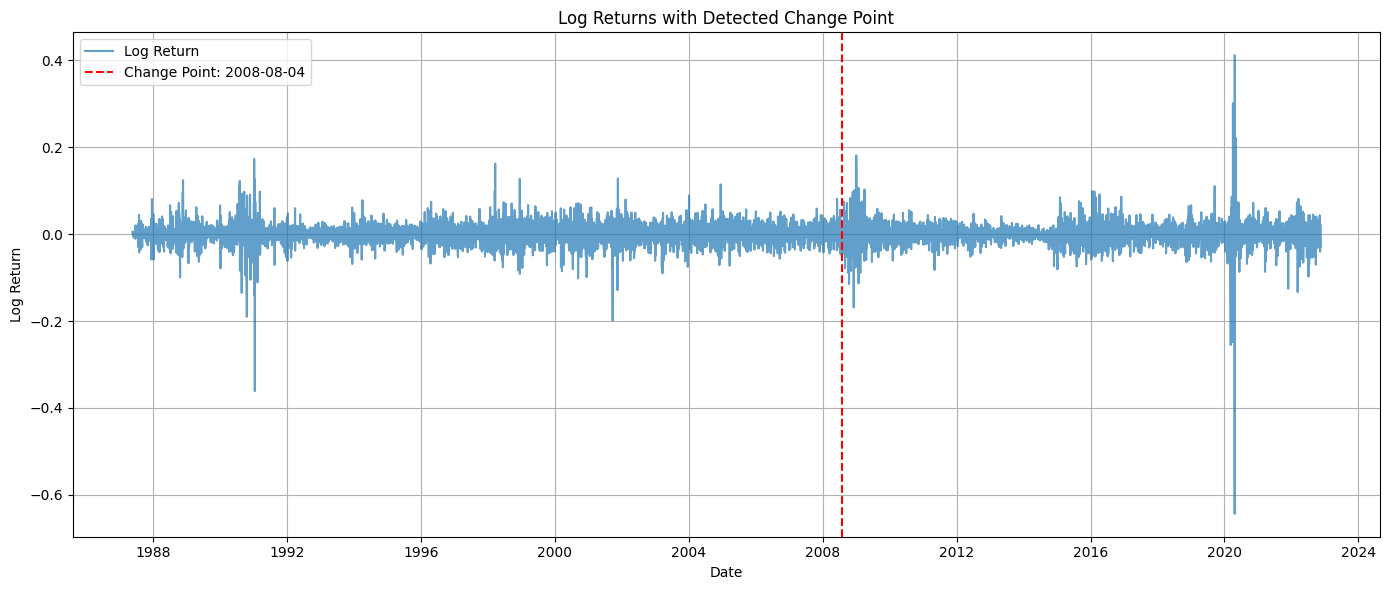

In [16]:
import matplotlib.pyplot as plt
import numpy as np

# Convert tau index to actual date
tau_median = int(np.median(trace.posterior["tau"].values))
change_date = df['Date'].iloc[tau_median]

# Plot log returns and changepoint
plt.figure(figsize=(14, 6))
plt.plot(df['Date'].iloc[1:], df['LogReturn'].iloc[1:], label="Log Return", alpha=0.7)

plt.axvline(change_date, color='red', linestyle='--', label=f"Change Point: {change_date.date()}")
plt.title("Log Returns with Detected Change Point")
plt.xlabel("Date")
plt.ylabel("Log Return")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


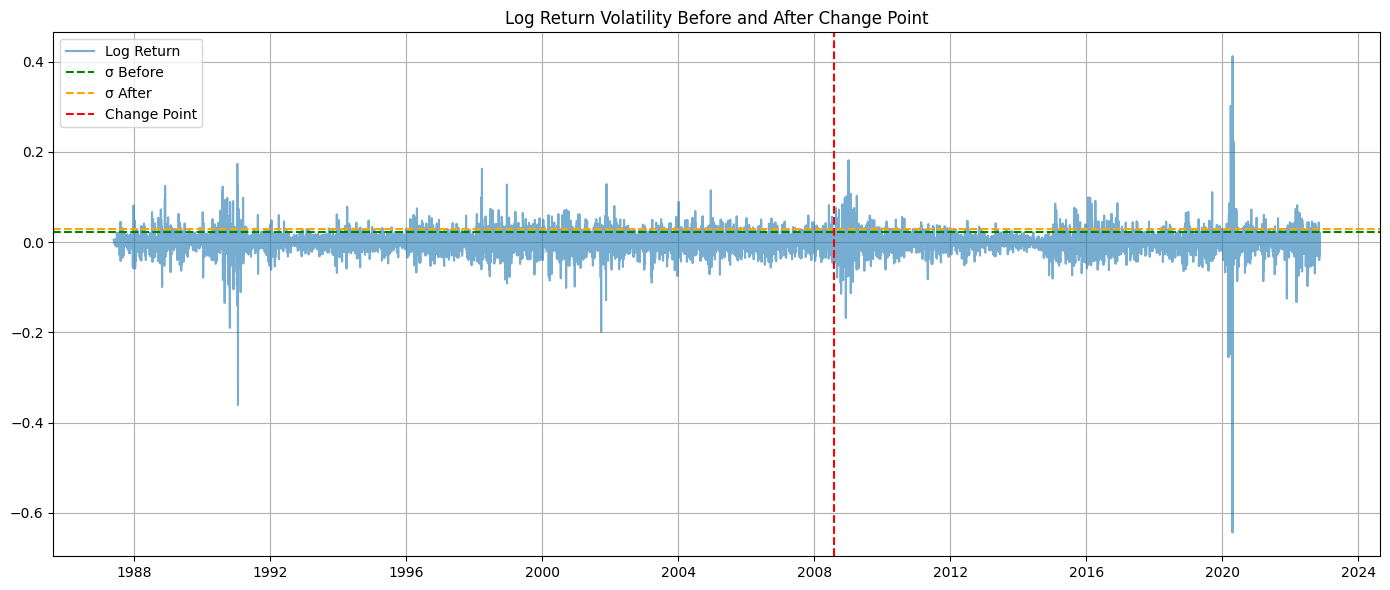

In [17]:
plt.figure(figsize=(14, 6))

plt.plot(df['Date'].iloc[1:], df['LogReturn'].iloc[1:], label="Log Return", alpha=0.6)

plt.axhline(y=trace.posterior["sigma1"].mean().values, color='green', linestyle='--', label='σ Before')
plt.axhline(y=trace.posterior["sigma2"].mean().values, color='orange', linestyle='--', label='σ After')
plt.axvline(change_date, color='red', linestyle='--', label="Change Point")
plt.title("Log Return Volatility Before and After Change Point")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


array([[<Axes: title={'center': 'tau\n0'}>,
        <Axes: title={'center': 'tau\n1'}>,
        <Axes: title={'center': 'tau\n2'}>],
       [<Axes: title={'center': 'tau\n3'}>,
        <Axes: title={'center': 'mu1\n0'}>,
        <Axes: title={'center': 'mu1\n1'}>],
       [<Axes: title={'center': 'mu1\n2'}>,
        <Axes: title={'center': 'mu1\n3'}>,
        <Axes: title={'center': 'mu2\n0'}>],
       [<Axes: title={'center': 'mu2\n1'}>,
        <Axes: title={'center': 'mu2\n2'}>,
        <Axes: title={'center': 'mu2\n3'}>]], dtype=object)

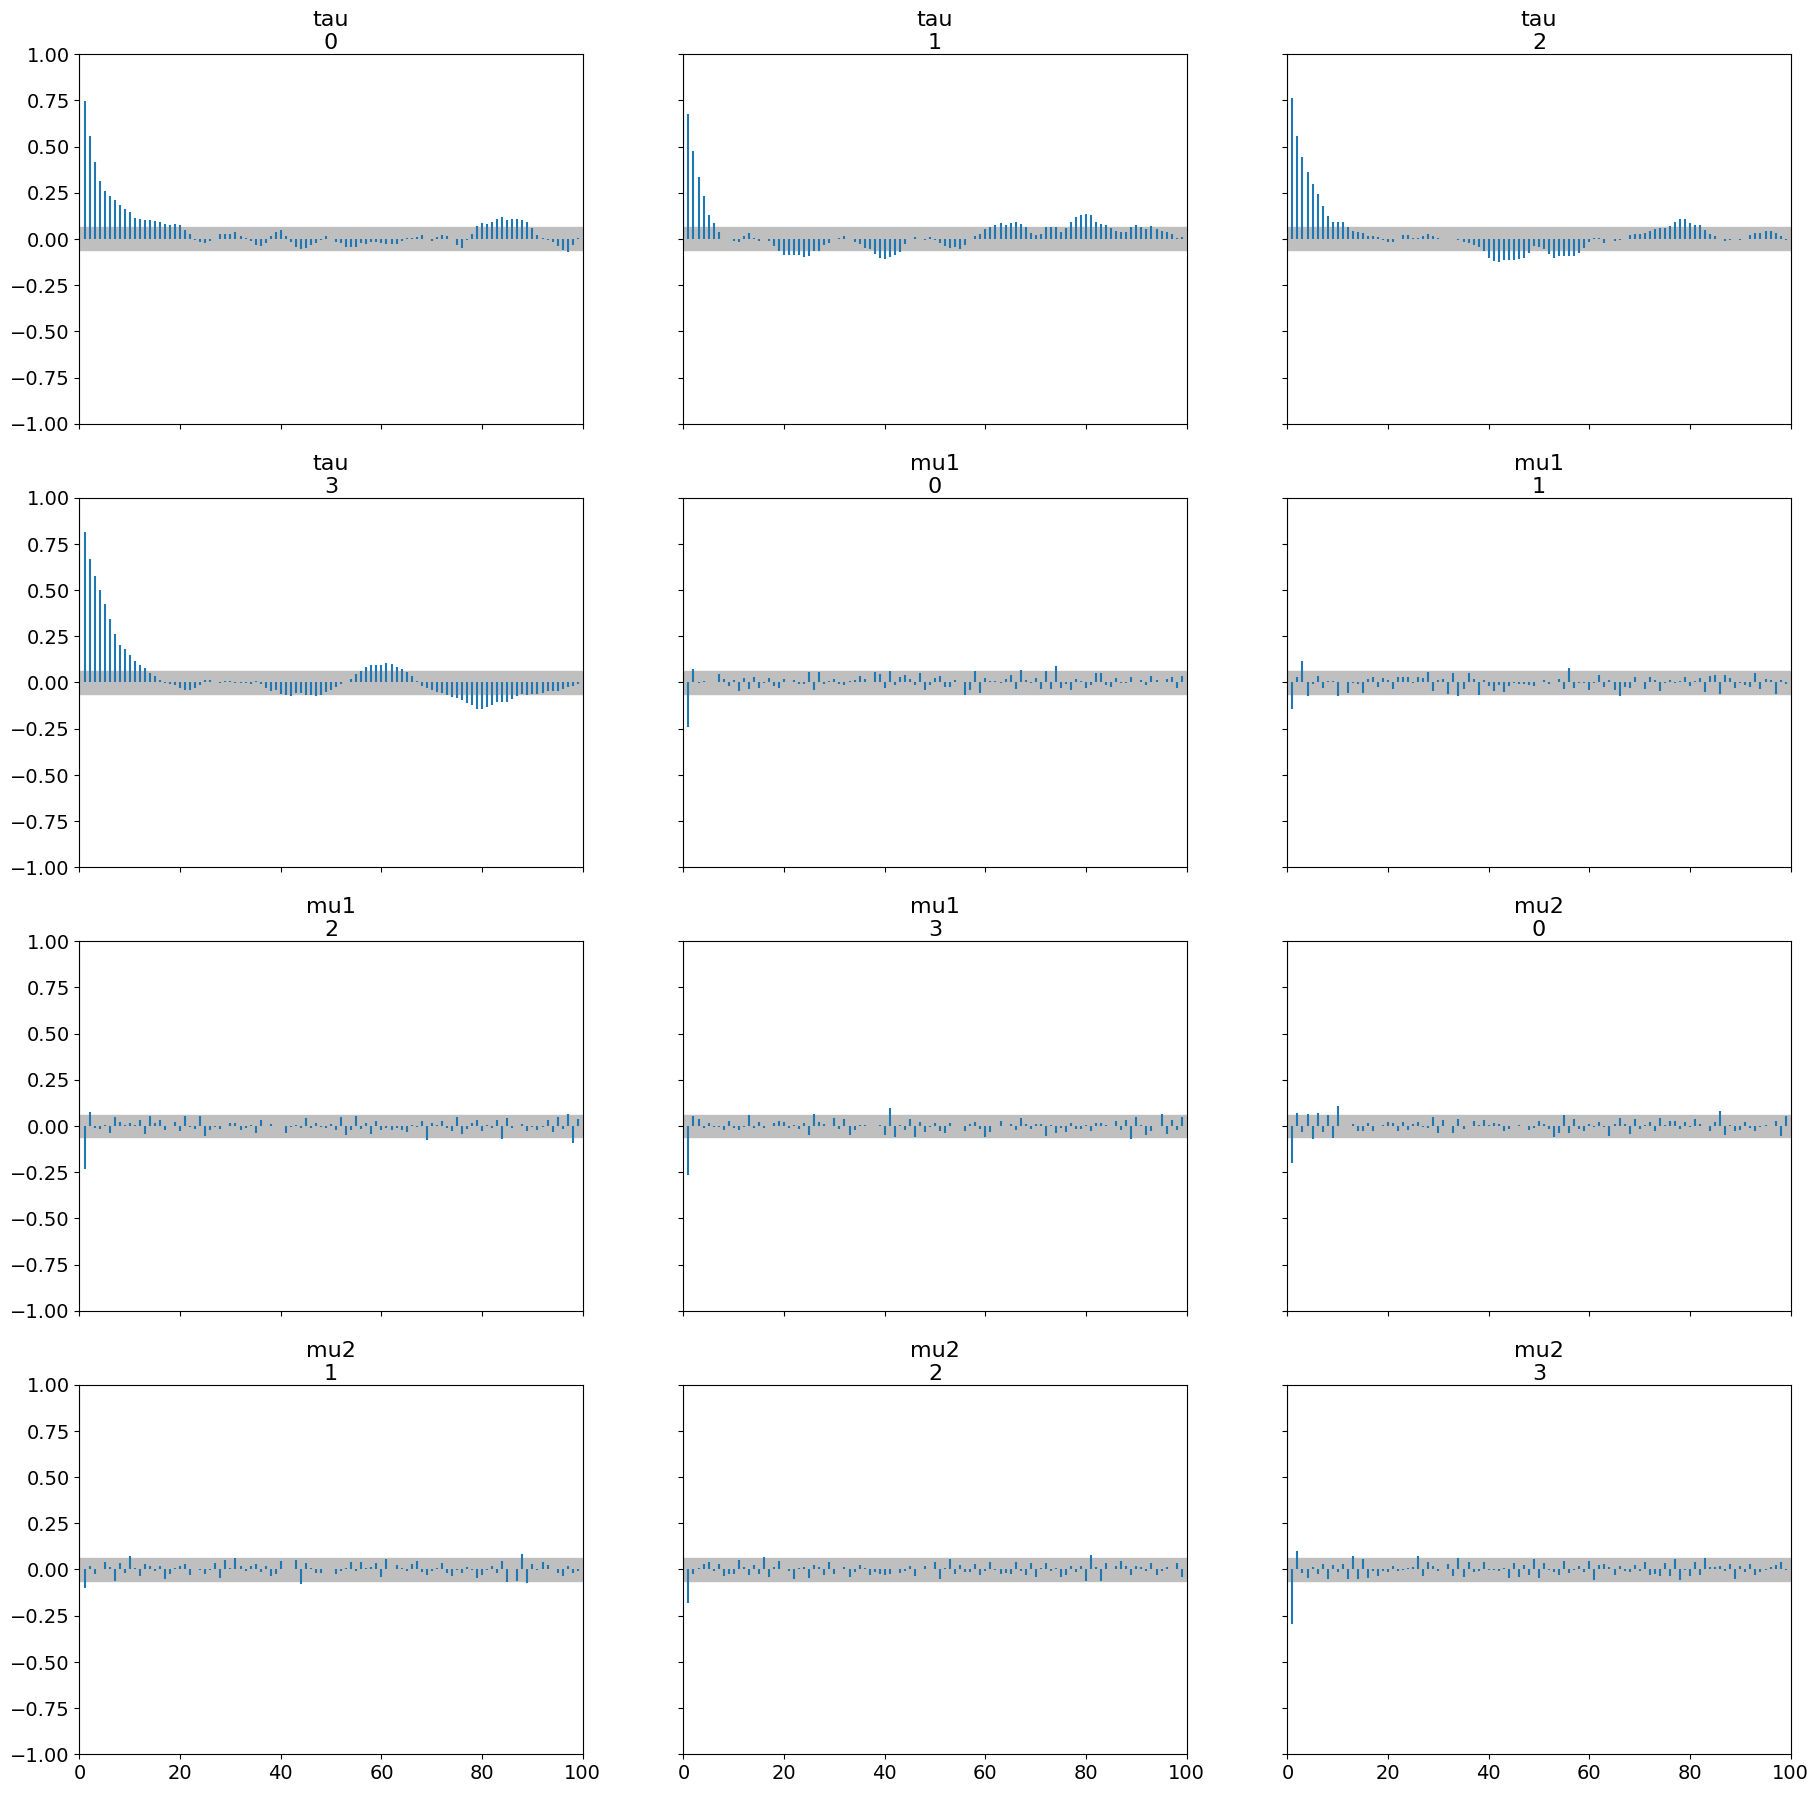

In [18]:
az.plot_autocorr(trace, var_names=["tau", "mu1", "mu2"])
